## Submodule-2.1 : Dynamical Systems

## Table of Contents
#### 1. [Neural ODE](#Neural-ODE)

#### 2. [Multi-step Neural Networks: Lorentz System](#Multi-step-Neural-Networks:-Lorentz-System)
#### 3. [Symplect Neural Networks (SympNet) : Pendulum System](#Symplect-Neural-Networks-(SympNet):-Pendulum-System)
#### 4. [Generic Formalism Informed Neural Network (GFINN): Two-Gas-Chambers](#Generic-Formalism-Informed-Neurals-Networks-(GFINN):-Two-Gas-Chambers)


In [1]:
!pip install torchdiffeq

You should consider upgrading via the '/Users/raj/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


## Neural ODE

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchdiffeq 
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

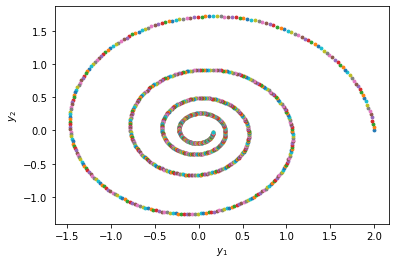

In [3]:
data_size=1000
method='dopri5'
batch_size=20
batch_time=10
niters=2000
test_freq=10
viz='store_true'
adjoint='store_true'

# Generate Training Data
y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
A = torch.tensor([[-0.1, 1.0], [-1.0, -0.1]])

class F(nn.Module):
    def forward(self, t, y):
        return torch.mm(y, A)
    
with torch.no_grad():
    y_actual = odeint(F(), y0, t, method='dopri5')

y_actual_np = y_actual.numpy()
shp = np.shape(y_actual)

for j in range(shp[0]):
    y1 = y_actual_np[j,0,0]
    y2 = y_actual_np[j,0,1]
    plt.scatter(y1, y2, s=8)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
        
def mini_batch():
    s_temp = np.arange(data_size - batch_time, dtype=np.int64)
    s = torch.from_numpy(np.random.choice(s_temp, batch_size, replace=False))
    batch_y0 = y_actual[s]  # (M, D)  # Batch_time 
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([y_actual[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

by0, bt, by = mini_batch()    

In [7]:
def visualize(true_y, pred_y, odefunc, itr):

    if viz:
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(131, frameon=False)
        ax_phase = fig.add_subplot(132, frameon=False)
        ax_vecfield = fig.add_subplot(133, frameon=False)
        
        #ax.set_title("Epoch: " + str(ep))
        
        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), y_actual.numpy()[:, 0, 0], t.numpy(), y_actual.numpy()[:, 0, 1], 'g-', label="Actual")
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--', label="Predicted")
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)

        ax_phase.cla()
        ax_phase.set_title('Phase')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(y_actual.numpy()[:, 0, 0], y_actual.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)
        fig.tight_layout()
        plt.draw()
        plt.pause(0.001)
        plt.show(block=False)
        return fig


Iter 00005 | Total Loss 0.95381469


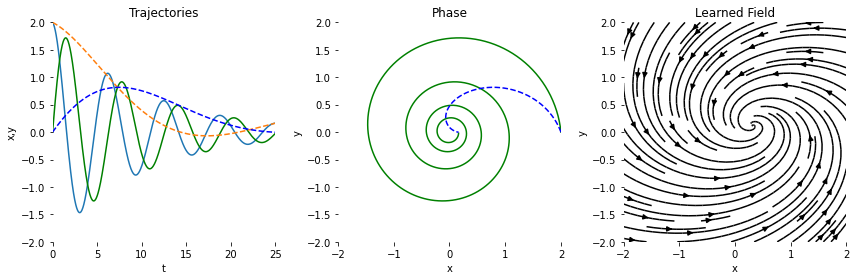

Iter 00010 | Total Loss 1.13396788


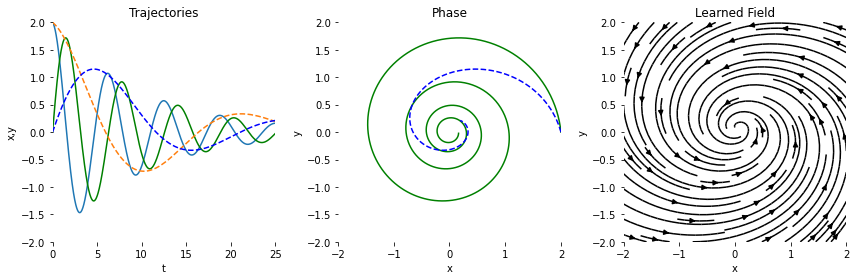

Iter 00015 | Total Loss 1.21790075


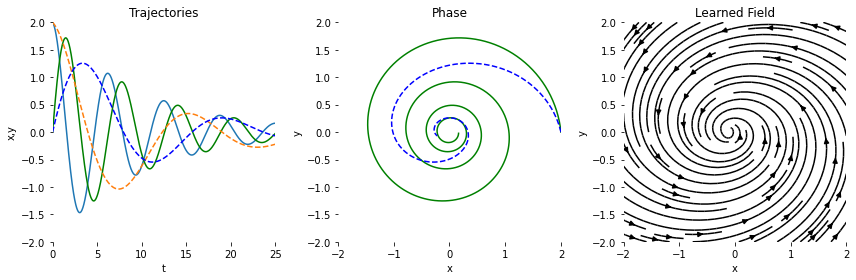

Iter 00020 | Total Loss 1.11139917


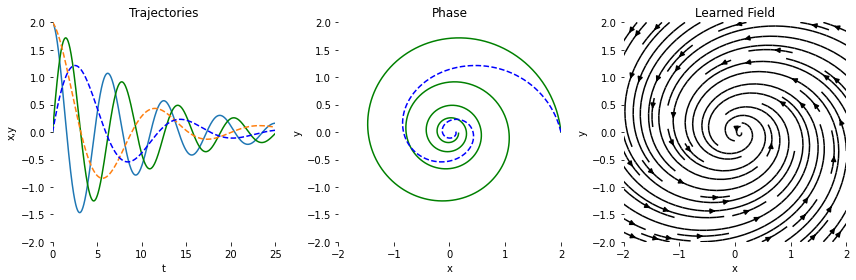

Iter 00025 | Total Loss 1.16875219


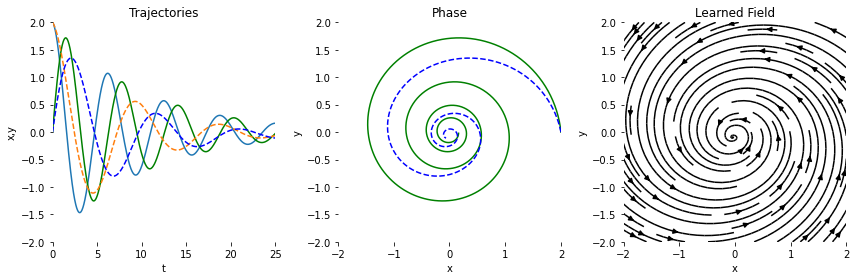

Iter 00030 | Total Loss 1.18406260


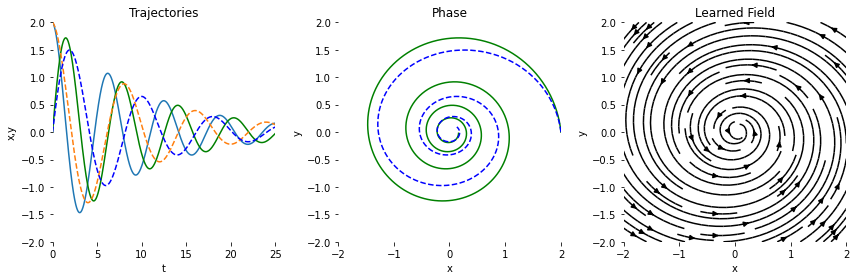

Iter 00035 | Total Loss 1.22220480


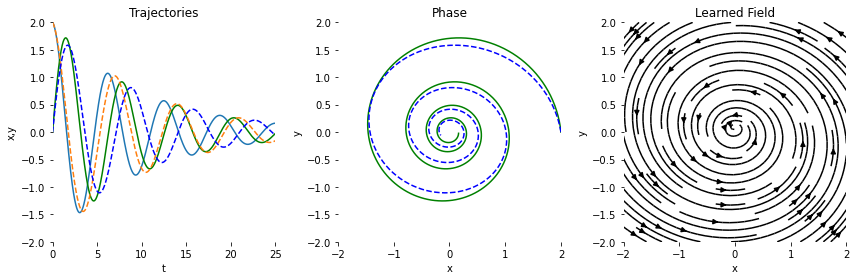

Iter 00040 | Total Loss 1.21581495


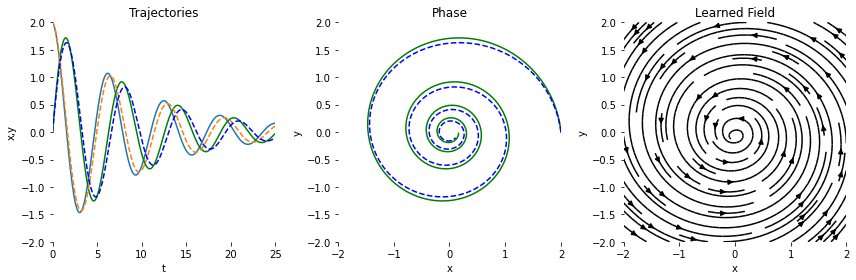

Iter 00045 | Total Loss 1.22870326


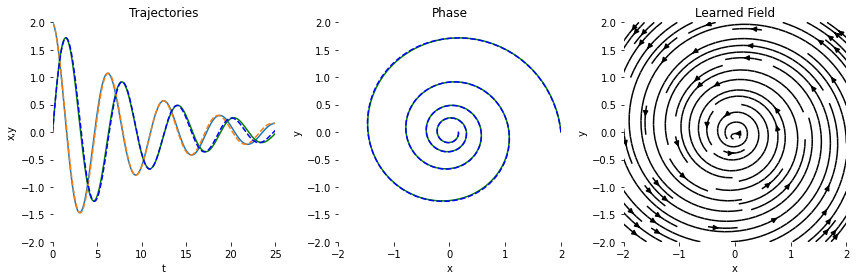

Iter 00050 | Total Loss 1.21738863


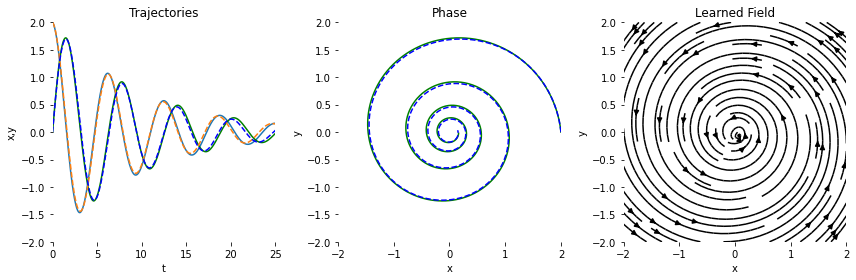

Iter 00055 | Total Loss 1.22386444


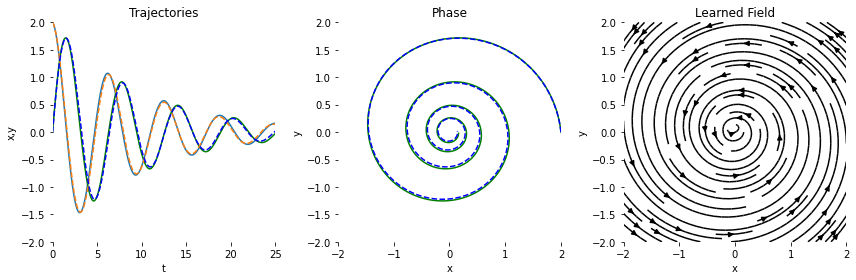

Iter 00060 | Total Loss 1.20156109


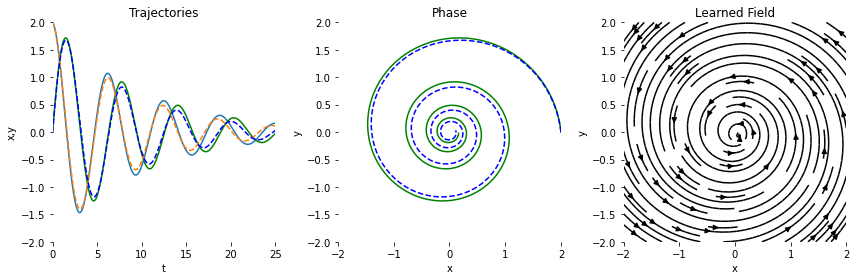

Iter 00065 | Total Loss 1.22798491


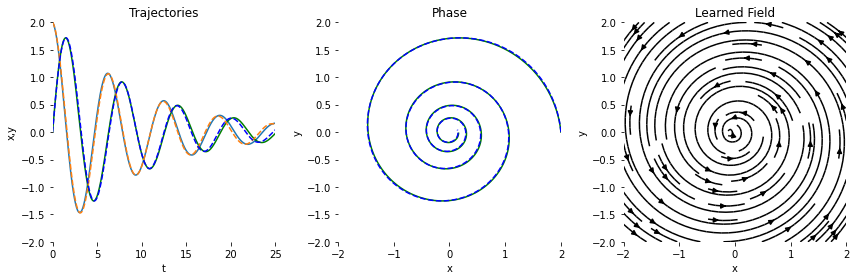

In [8]:
import imageio

class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 2),
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
p = 0
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
niters = 65
image_list = []

for it in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = mini_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if it % 5 == 0:
        with torch.no_grad():
            pred_y = odeint(func, y0, t)
            loss = torch.mean(torch.abs(pred_y - y0))
            print('Iter {:05d} | Total Loss {:.8f}'.format(it, loss.item()))
            fig=visualize(y0, pred_y, func, p)
            fig.canvas.draw()      
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            image_list.append(image)
            p += 1
            

imageio.mimsave('./Dynamic_system.gif', image_list, fps=2)

## Multi-step Neural Networks: Lorentz System

In [1]:
%%html
<style type='text/css'>
.CodeMirror{
    font-size: 18px;
}

div.output_area pre {
    font-size: 20px;
}
</style>

In [89]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys


In [96]:
import numpy as np
import tensorflow as tf
import nodepy.linear_multistep_method as lm
import timeit
np.random.seed(1234)
tf.random.set_seed(1234)
class Multistep_NN:
    def __init__(self, dt, X, Xstar, layers, M, scheme):
        self.dt = dt
        self.X = X # S x N x D
        self.X_star = Xstar
        self.S = X.shape[0] # number of trajectories
        self.N = X.shape[1] # number of time snapshots
        self.D = X.shape[2] # number of dimensions
        self.M = M # number of Adams-Moulton steps
        self.layers = layers
        
        L = len(layers)
        switch = {'AM': lm.Adams_Moulton,
                  'AB': lm.Adams_Bashforth,
                  'BDF': lm.backward_difference_formula}
        method = switch[scheme](M)
        self.alpha = np.float32(-method.alpha[::-1])
        self.beta = np.float32(method.beta[::-1])
        self.X = self.X.reshape((self.S, -1, self.D))
        # S x N x D 
        self.X_tf = tf.convert_to_tensor(self.X, dtype=tf.float32) 
        # N_star x D
        self.X_star_tf = tf.convert_to_tensor(self.X_star, dtype=tf.float32)  
        
        self.W = [self.hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
        self.b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]
        # Optimizer and Learning Rate
        self.lr=0.0001
        self.opt = tf.optimizers.Adam(learning_rate=self.lr)
       
        
    def loss(self):
        Y_pred = self.net_Y(self.X_tf) # S x N x D
        loss = self.D*tf.reduce_mean(tf.square(Y_pred))     
        return loss
    
    def hyper_initial(self, size):
        in_dim = size[0]
        out_dim = size[1]
        std = np.sqrt(2.0/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))
    
    def neural_net(self, X):
        A = X
        L = len(self.W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, self.W[i]), self.b[i]))
        Y = tf.add(tf.matmul(A, self.W[-1]), self.b[-1])
        return Y
    
    def train_vars(self):
        return self.W + self.b
    
     
    def net_F(self, X): # S x (N-M+1) x D
        X_reshaped = tf.reshape(X, [-1,self.D]) # S(N-M+1) x D
        F_reshaped = self.neural_net(X_reshaped) # S(N-M+1) x D
        F = tf.reshape(F_reshaped, [self.S,-1,self.D]) # S x (N-M+1) x D
        return F # S x (N-M+1) x D
    
    def net_Y(self, X): # S x N x D
        M = self.M        
        Y = self.alpha[0]*X[:,M:,:] + self.dt*self.beta[0]*self.net_F(X[:,M:,:])
        for m in range(1, M+1):
            Y = Y + self.alpha[m]*X[:,M-m:-m,:] \
            + self.dt*self.beta[m]*self.net_F(X[:,M-m:-m,:]) # S x (N-M+1) x D
        
        return Y # S x (N-M+1) x D
    
    
    def predict_f(self, X_star):
        
        X_star = X_star.reshape((-1, self.D))
        X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)
        f_pred = self.neural_net(X_star_tf) # N_star x D
        return f_pred

    
    
    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            tape.watch([self.W, self.b])
            loss = self.loss()
        grads = tape.gradient(loss, self.train_vars())
        self.opt.apply_gradients(zip(grads, self.train_vars()))        
        return loss
    

    
    def train(self, N_Iter):
        for it in range(N_Iter):
            loss_ = self.train_step()
            if it % 50 == 0:
                print(f"Iteration is: {it} and loss is: {loss_}")
                
   
    


    
# time points
t_star = np.arange(0,25,0.01)
# initial condition
x0 = np.array([-8.0, 7.0, 27])
    
# solve ODE
def f(x,t): # x is 3 x 1
    sigma = 10.0
    beta = 8.0/3.0
    rho = 28.0
       
    f1 = sigma*(x[1]-x[0])
    f2 = x[0]*(rho-x[2])-x[1]
    f3 = x[0]*x[1]-beta*x[2]
    f = np.array([f1,f2,f3])
    return f

X_star = odeint(f, x0, t_star)
noise = 0.00
skip = 1
dt = t_star[skip] - t_star[0]
X_train = X_star[0::skip,:]
X_train = X_train + noise*X_train.std(0)*np.random.randn(X_train.shape[0], X_train.shape[1])
X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))
layers = [3, 256, 3]
M = 1
scheme = 'AM'
model = Multistep_NN(dt, X_train,X_star, layers, M, scheme)
N_Iter = 50001
model.train(N_Iter)

Iteration is: 0 and loss is: 1.252354383468628
Iteration is: 50 and loss is: 1.241541862487793
Iteration is: 100 and loss is: 1.2303212881088257
Iteration is: 150 and loss is: 1.2182374000549316
Iteration is: 200 and loss is: 1.205457091331482
Iteration is: 250 and loss is: 1.1921217441558838
Iteration is: 300 and loss is: 1.1784049272537231
Iteration is: 350 and loss is: 1.1645195484161377
Iteration is: 400 and loss is: 1.1509554386138916
Iteration is: 450 and loss is: 1.1381731033325195
Iteration is: 500 and loss is: 1.1259063482284546
Iteration is: 550 and loss is: 1.1137263774871826
Iteration is: 600 and loss is: 1.101531744003296
Iteration is: 650 and loss is: 1.0897126197814941
Iteration is: 700 and loss is: 1.0783843994140625
Iteration is: 750 and loss is: 1.0674023628234863
Iteration is: 800 and loss is: 1.0567128658294678
Iteration is: 850 and loss is: 1.0462931394577026
Iteration is: 900 and loss is: 1.0360840559005737
Iteration is: 950 and loss is: 1.0259110927581787
Iterati

Iteration is: 8100 and loss is: 0.3186500668525696
Iteration is: 8150 and loss is: 0.3162069320678711
Iteration is: 8200 and loss is: 0.31378209590911865
Iteration is: 8250 and loss is: 0.31137537956237793
Iteration is: 8300 and loss is: 0.3089855909347534
Iteration is: 8350 and loss is: 0.3065726161003113
Iteration is: 8400 and loss is: 0.3041936755180359
Iteration is: 8450 and loss is: 0.3018421232700348
Iteration is: 8500 and loss is: 0.2995128631591797
Iteration is: 8550 and loss is: 0.29720398783683777
Iteration is: 8600 and loss is: 0.29491469264030457
Iteration is: 8650 and loss is: 0.2926441431045532
Iteration is: 8700 and loss is: 0.2903919219970703
Iteration is: 8750 and loss is: 0.28815752267837524
Iteration is: 8800 and loss is: 0.28594058752059937
Iteration is: 8850 and loss is: 0.28374093770980835
Iteration is: 8900 and loss is: 0.2815583348274231
Iteration is: 8950 and loss is: 0.2793926000595093
Iteration is: 9000 and loss is: 0.2772434651851654
Iteration is: 9050 and l

Iteration is: 15950 and loss is: 0.0943140834569931
Iteration is: 16000 and loss is: 0.09354092925786972
Iteration is: 16050 and loss is: 0.09277419745922089
Iteration is: 16100 and loss is: 0.09201366454362869
Iteration is: 16150 and loss is: 0.09125909209251404
Iteration is: 16200 and loss is: 0.09051026403903961
Iteration is: 16250 and loss is: 0.08976706862449646
Iteration is: 16300 and loss is: 0.08902915567159653
Iteration is: 16350 and loss is: 0.08829624205827713
Iteration is: 16400 and loss is: 0.08756783604621887
Iteration is: 16450 and loss is: 0.08684364706277847
Iteration is: 16500 and loss is: 0.08612364530563354
Iteration is: 16550 and loss is: 0.0854078084230423
Iteration is: 16600 and loss is: 0.08469534665346146
Iteration is: 16650 and loss is: 0.08398707211017609
Iteration is: 16700 and loss is: 0.08328383415937424
Iteration is: 16750 and loss is: 0.08258549869060516
Iteration is: 16800 and loss is: 0.08189110457897186
Iteration is: 16850 and loss is: 0.0811999738216

Iteration is: 23650 and loss is: 0.022160181775689125
Iteration is: 23700 and loss is: 0.021928098052740097
Iteration is: 23750 and loss is: 0.021698832511901855
Iteration is: 23800 and loss is: 0.021472152322530746
Iteration is: 23850 and loss is: 0.021247945725917816
Iteration is: 23900 and loss is: 0.02102627418935299
Iteration is: 23950 and loss is: 0.020807113498449326
Iteration is: 24000 and loss is: 0.020590292289853096
Iteration is: 24050 and loss is: 0.020375676453113556
Iteration is: 24100 and loss is: 0.020163368433713913
Iteration is: 24150 and loss is: 0.019953371956944466
Iteration is: 24200 and loss is: 0.019745664671063423
Iteration is: 24250 and loss is: 0.019540198147296906
Iteration is: 24300 and loss is: 0.01933690719306469
Iteration is: 24350 and loss is: 0.019135769456624985
Iteration is: 24400 and loss is: 0.018936745822429657
Iteration is: 24450 and loss is: 0.018739687278866768
Iteration is: 24500 and loss is: 0.018544523045420647
Iteration is: 24550 and loss i

Iteration is: 31300 and loss is: 0.004120040684938431
Iteration is: 31350 and loss is: 0.004072156734764576
Iteration is: 31400 and loss is: 0.004025137517601252
Iteration is: 31450 and loss is: 0.003978723660111427
Iteration is: 31500 and loss is: 0.0039328718557953835
Iteration is: 31550 and loss is: 0.003887464525178075
Iteration is: 31600 and loss is: 0.003842345904558897
Iteration is: 31650 and loss is: 0.003797331126406789
Iteration is: 31700 and loss is: 0.0037523775827139616
Iteration is: 31750 and loss is: 0.0037078766617923975
Iteration is: 31800 and loss is: 0.00366407772526145
Iteration is: 31850 and loss is: 0.0036209682002663612
Iteration is: 31900 and loss is: 0.0035781189799308777
Iteration is: 31950 and loss is: 0.0035342162009328604
Iteration is: 32000 and loss is: 0.003490303410217166
Iteration is: 32050 and loss is: 0.003448035102337599
Iteration is: 32100 and loss is: 0.0034070536494255066
Iteration is: 32150 and loss is: 0.003366888500750065
Iteration is: 32200 an

Iteration is: 38800 and loss is: 0.00047965836711227894
Iteration is: 38850 and loss is: 0.00047088973224163055
Iteration is: 38900 and loss is: 0.0004630850162357092
Iteration is: 38950 and loss is: 0.0004557201755233109
Iteration is: 39000 and loss is: 0.00044859692570753396
Iteration is: 39050 and loss is: 0.00044164550490677357
Iteration is: 39100 and loss is: 0.0004348429210949689
Iteration is: 39150 and loss is: 0.0004281593719497323
Iteration is: 39200 and loss is: 0.00042159610893577337
Iteration is: 39250 and loss is: 0.00041514422628097236
Iteration is: 39300 and loss is: 0.0004088053246960044
Iteration is: 39350 and loss is: 0.00040256843203678727
Iteration is: 39400 and loss is: 0.00039643445052206516
Iteration is: 39450 and loss is: 0.00039043015567585826
Iteration is: 39500 and loss is: 0.00038446730468422174
Iteration is: 39550 and loss is: 0.0003786231391131878
Iteration is: 39600 and loss is: 0.0003728711453732103
Iteration is: 39650 and loss is: 0.00036721467040479183

Iteration is: 46200 and loss is: 4.647162859328091e-05
Iteration is: 46250 and loss is: 4.5902888814453036e-05
Iteration is: 46300 and loss is: 4.53715147159528e-05
Iteration is: 46350 and loss is: 4.479968993109651e-05
Iteration is: 46400 and loss is: 4.426342638907954e-05
Iteration is: 46450 and loss is: 4.373676347313449e-05
Iteration is: 46500 and loss is: 4.322164022596553e-05
Iteration is: 46550 and loss is: 4.273341619409621e-05
Iteration is: 46600 and loss is: 4.221822018735111e-05
Iteration is: 46650 and loss is: 4.172958142589778e-05
Iteration is: 46700 and loss is: 4.1244507883675396e-05
Iteration is: 46750 and loss is: 4.076857294421643e-05
Iteration is: 46800 and loss is: 4.0301769331563264e-05
Iteration is: 46850 and loss is: 3.984369686804712e-05
Iteration is: 46900 and loss is: 3.937221481464803e-05
Iteration is: 46950 and loss is: 3.894004476023838e-05
Iteration is: 47000 and loss is: 3.8449947169283405e-05
Iteration is: 47050 and loss is: 3.7988502299413085e-05
Iterat

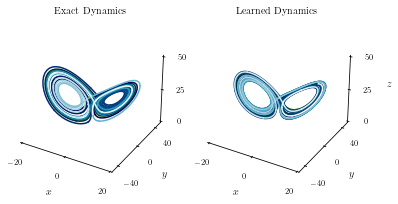

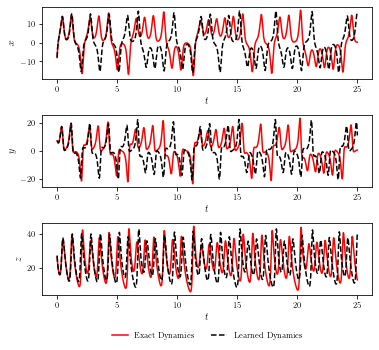

In [97]:
from  plotting import newfig, savefig
import matplotlib.gridspec as gridspec
def learned_f(x,t):
    f = model.predict_f(x[None,:])
    return tf.reshape(f, [-1])

def colorline3d(ax, x, y, z, cmap):
    N = len(x)
    skip = int(0.01*N)
    for i in range(0,N,skip):
        ax.plot(x[i:i+skip+1], y[i:i+skip+1], z[i:i+skip+1], color=cmap(int(255*i/N)))

learned_X_star = odeint(learned_f, x0, t_star)

fig, ax = newfig(1.0, 0.8)
ax.axis('off')

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=0.95, bottom=0.1, left=0.0, right=0.90, wspace=0.15)

ax = plt.subplot(gs0[:, 0:1], projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
colorline3d(ax, X_star[:,0], X_star[:,1], X_star[:,2], cmap = plt.cm.ocean)
ax.grid(False)
ax.set_xlim([-20,20])
ax.set_ylim([-50,50])
ax.set_zlim([0,50])
ax.set_xticks([-20,0,20])
ax.set_yticks([-40,0,40])
ax.set_zticks([0,25,50])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Exact Dynamics', fontsize = 10)

ax = plt.subplot(gs0[:, 1:2], projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))    
colorline3d(ax, learned_X_star[:,0], learned_X_star[:,1], learned_X_star[:,2], cmap = plt.cm.ocean)
ax.grid(False)
ax.set_xlim([-20,20])
ax.set_ylim([-50,50])
ax.set_zlim([0,50])
ax.set_xticks([-20,0,20])
ax.set_yticks([-40,0,40])
ax.set_zticks([0,25,50])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Learned Dynamics', fontsize = 10)

savefig('./figures/Lorenz', crop = False)

####### Plotting ##################

fig, ax = newfig(1.0, 1.5)
ax.axis('off')

gs0 = gridspec.GridSpec(3, 1)
gs0.update(top=0.95, bottom=0.15, left=0.1, right=0.95, hspace=0.5)

ax = plt.subplot(gs0[0:1, 0:1])
ax.plot(t_star,X_star[:,0],'r-')
ax.plot(t_star,learned_X_star[:,0],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

ax = plt.subplot(gs0[1:2, 0:1])
ax.plot(t_star,X_star[:,1],'r-')
ax.plot(t_star,learned_X_star[:,1],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')

ax = plt.subplot(gs0[2:3, 0:1])
ax.plot(t_star,X_star[:,2],'r-',label='Exact Dynamics')
ax.plot(t_star,learned_X_star[:,2],'k--',label='Learned Dynamics')
ax.set_xlabel('$t$')
ax.set_ylabel('$z$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2, frameon=False)
savefig('./figures/Lorenz_Traj', crop = False)


## Symplectic-Neural-Networks-(SympNet):-Pendulum-System

Training...
0        Train loss: 0.002846713410690427     Test loss: 0.0031812123488634825    
1000     Train loss: 3.4585598314151866e-06   Test loss: 3.8601992855547e-06      
2000     Train loss: 3.302764980617212e-06    Test loss: 3.7985987546562683e-06   
3000     Train loss: 3.0622311442130012e-06   Test loss: 3.523044824760291e-06    
4000     Train loss: 2.696316641959129e-06    Test loss: 3.0892715585650876e-06   
5000     Train loss: 2.218516101493151e-06    Test loss: 2.5578951863280963e-06   
6000     Train loss: 1.6948691836660146e-06   Test loss: 1.9593508113757707e-06   
7000     Train loss: 1.2540026546048466e-06   Test loss: 1.3486803709383821e-06   
8000     Train loss: 8.732507694730884e-07    Test loss: 9.977323998100474e-07    
9000     Train loss: 5.735992090194486e-07    Test loss: 6.731656299052702e-07    
10000    Train loss: 3.9258625861293694e-07   Test loss: 4.388811305489071e-07    
11000    Train loss: 4.429624880231131e-07    Test loss: 3.899865248513379e

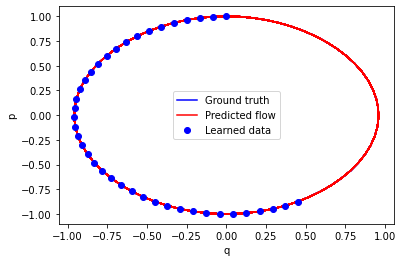

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import learner as ln
from learner.integrator.hamiltonian import SV

DIM=2

class PDData(ln.Data):
    '''Data for learning the pendulum system with the Hamiltonian H(p,q)=(1/2)p^2−cos(q).
    '''
    def __init__(self, x0, h, train_num, test_num, add_h=False):
        super(PDData, self).__init__()
        self.dH = lambda p, q: (p, np.sin(q))
        self.solver = SV(None, self.dH, iterations=1, order=6, N=10)
        self.x0 = x0
        self.h = h
        self.train_num = train_num
        self.test_num = test_num
        self.add_h = add_h
        self.__init_data()
        
    @property
    def dim(self):
        return DIM
    
    def __generate_flow(self, x0, h, num):
        X = self.solver.flow(np.array(x0), h, num)
        x, y = X[:-1], X[1:]
        if self.add_h:
            x = np.hstack([x, self.h * np.ones([x.shape[0], 1])])
        return x, y
    
    def __init_data(self):
        self.X_train, self.y_train = self.__generate_flow(self.x0, self.h, self.train_num)
        self.X_test, self.y_test = self.__generate_flow(self.y_train[-1], self.h, self.test_num)
        
def plot(data, net):
    steps = 1000
    if isinstance(net, ln.nn.HNN):
        flow_true = data.solver.flow(data.X_test_np[0][:-1], data.h, steps)
        flow_pred = net.predict(data.X_test[0][:-1], data.h, steps, keepinitx=True, returnnp=True)
    else:
        flow_true = data.solver.flow(data.X_test_np[0], data.h, steps)
        flow_pred = net.predict(data.X_test[0], steps, keepinitx=True, returnnp=True)
    
    plt.plot(flow_true[:, 0], flow_true[:, 1], color='b', label='Ground truth', zorder=0)
    plt.plot(flow_pred[:, 0], flow_pred[:, 1], color='r', label='Predicted flow', zorder=1)
    plt.scatter(data.X_train_np[:, 0], data.X_train_np[:, 1], color='b', label='Learned data', zorder=2)
    plt.xlabel("q")
    plt.ylabel("p")
    plt.legend()
    plt.savefig('pendulum.pdf')

def main():
    device = 'cpu' # 'cpu' or 'gpu'
    # data
    x0 = [0, 1]
    h = 0.1
    train_num = 40
    test_num = 100
    # net
    net_type = 'LA' # 'LA' or 'G' or 'HNN'
    LAlayers = 3
    LAsublayers = 2
    Glayers = 5
    Gwidth = 30
    activation = 'sigmoid'
    Hlayers = 4
    Hwidth = 30
    Hactivation = 'tanh'
    # training
    lr = 0.001
    iterations = 50000
    print_every = 1000
    
    add_h = True if net_type == 'HNN' else False
    criterion = None if net_type == 'HNN' else 'MSE'
    data = PDData(x0, h, train_num, test_num, add_h)
    if net_type == 'LA':
        net = ln.nn.LASympNet(data.dim, LAlayers, LAsublayers, activation)
    elif net_type == 'G':
        net = ln.nn.GSympNet(data.dim, Glayers, Gwidth, activation)
    elif net_type == 'HNN':
        net = ln.nn.HNN(data.dim, Hlayers, Hwidth, Hactivation)
    args = {
        'data': data,
        'net': net,
        'criterion': criterion,
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'batch_size': None,
        'print_every': print_every,
        'save': True,
        'callback': None,
        'dtype': 'float',
        'device': device
    }
    
    ln.Brain.Init(**args)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    
    plot(data, ln.Brain.Best_model())
    
if __name__ == '__main__':
    main()

## Generic Formalism Informed Neurals Networks-(GFINN): Two Gas Chambers

Training...
 ADAM || It: 00000, Loss: 1.0242e-02, Test: 2.3221e-03
 ADAM || It: 00100, Loss: 2.1095e-04, Test: 8.6239e-05
 ADAM || It: 00200, Loss: 1.1608e-05, Test: 2.0376e-05
 ADAM || It: 00300, Loss: 7.2148e-06, Test: 1.2482e-05
 ADAM || It: 00400, Loss: 2.1943e-05, Test: 1.3432e-05
 ADAM || It: 00500, Loss: 8.8143e-06, Test: 1.0790e-05
 ADAM || It: 00600, Loss: 1.9046e-05, Test: 1.0656e-05
 ADAM || It: 00700, Loss: 7.5142e-06, Test: 1.1230e-05
 ADAM || It: 00800, Loss: 1.7163e-05, Test: 1.0077e-05
 ADAM || It: 00900, Loss: 5.2028e-06, Test: 9.5864e-06
 ADAM || It: 01000, Loss: 9.2953e-06, Test: 1.0006e-05
 ADAM || It: 01100, Loss: 1.8879e-05, Test: 1.5663e-05
 ADAM || It: 01200, Loss: 6.7728e-06, Test: 9.4708e-06
 ADAM || It: 01300, Loss: 8.1997e-06, Test: 1.0564e-05
 ADAM || It: 01400, Loss: 6.7744e-06, Test: 8.7334e-06
 ADAM || It: 01500, Loss: 2.0443e-05, Test: 7.7488e-06
 ADAM || It: 01600, Loss: 1.6172e-05, Test: 3.0979e-05
 ADAM || It: 01700, Loss: 4.4919e-05, Test: 1.2564e-0

 ADAM || It: 14900, Loss: 1.4466e-07, Test: 1.0489e-07
 ADAM || It: 15000, Loss: 4.6698e-08, Test: 8.4169e-08
 ADAM || It: 15100, Loss: 1.5714e-07, Test: 2.4936e-07
 ADAM || It: 15200, Loss: 1.3858e-07, Test: 3.0172e-07
 ADAM || It: 15300, Loss: 1.0993e-07, Test: 2.5101e-07
 ADAM || It: 15400, Loss: 2.0482e-08, Test: 9.1922e-08
 ADAM || It: 15500, Loss: 3.0673e-08, Test: 8.0501e-08
 ADAM || It: 15600, Loss: 1.4891e-07, Test: 3.4012e-07
 ADAM || It: 15700, Loss: 1.0751e-06, Test: 1.8458e-06
 ADAM || It: 15800, Loss: 7.9926e-07, Test: 5.8787e-07
 ADAM || It: 15900, Loss: 1.0200e-06, Test: 1.1155e-06
 ADAM || It: 16000, Loss: 6.4874e-07, Test: 1.7889e-06
 ADAM || It: 16100, Loss: 1.5685e-06, Test: 9.3220e-07
 ADAM || It: 16200, Loss: 4.9217e-08, Test: 2.8560e-07
 ADAM || It: 16300, Loss: 1.1665e-07, Test: 1.8851e-07
 ADAM || It: 16400, Loss: 6.5170e-08, Test: 1.3281e-07
 ADAM || It: 16500, Loss: 5.1358e-08, Test: 1.4781e-07
 ADAM || It: 16600, Loss: 7.3100e-08, Test: 1.6279e-07
 ADAM || I

 ADAM || It: 29800, Loss: 1.7375e-08, Test: 3.2425e-08
 ADAM || It: 29900, Loss: 1.6111e-07, Test: 2.2328e-07
 ADAM || It: 30000, Loss: 1.4506e-07, Test: 5.6350e-07
 ADAM || It: 30100, Loss: 6.8939e-08, Test: 2.6816e-08
 ADAM || It: 30200, Loss: 8.4540e-08, Test: 1.9051e-07
 ADAM || It: 30300, Loss: 1.5599e-08, Test: 2.4163e-08
 ADAM || It: 30400, Loss: 2.1606e-08, Test: 5.6450e-08
 ADAM || It: 30500, Loss: 2.5368e-08, Test: 2.3936e-08
 ADAM || It: 30600, Loss: 4.4900e-07, Test: 3.0212e-07
 ADAM || It: 30700, Loss: 2.5382e-08, Test: 2.9028e-08
 ADAM || It: 30800, Loss: 1.1319e-07, Test: 2.0172e-08
 ADAM || It: 30900, Loss: 3.3264e-08, Test: 3.8218e-08
 ADAM || It: 31000, Loss: 4.2225e-08, Test: 1.1762e-07
 ADAM || It: 31100, Loss: 1.5645e-08, Test: 4.3625e-08
 ADAM || It: 31200, Loss: 2.3549e-07, Test: 2.6617e-07
 ADAM || It: 31300, Loss: 1.5029e-06, Test: 1.8241e-06
 ADAM || It: 31400, Loss: 8.1138e-09, Test: 3.0740e-08
 ADAM || It: 31500, Loss: 2.5053e-08, Test: 6.9575e-08
 ADAM || I

 ADAM || It: 44700, Loss: 1.0972e-08, Test: 2.2155e-08
 ADAM || It: 44800, Loss: 7.5699e-07, Test: 1.1787e-06
 ADAM || It: 44900, Loss: 1.0856e-08, Test: 2.2718e-08
 ADAM || It: 45000, Loss: 1.0518e-08, Test: 4.1952e-08
 ADAM || It: 45100, Loss: 2.0388e-09, Test: 1.4418e-08
 ADAM || It: 45200, Loss: 5.0761e-08, Test: 7.0670e-08
 ADAM || It: 45300, Loss: 8.9998e-09, Test: 2.1422e-08
 ADAM || It: 45400, Loss: 4.5345e-08, Test: 5.3354e-08
 ADAM || It: 45500, Loss: 6.9652e-09, Test: 1.6375e-08
 ADAM || It: 45600, Loss: 1.7303e-07, Test: 4.6363e-07
 ADAM || It: 45700, Loss: 4.5476e-08, Test: 9.4370e-08
 ADAM || It: 45800, Loss: 1.9237e-07, Test: 2.1855e-07
 ADAM || It: 45900, Loss: 4.3887e-08, Test: 2.9922e-08
 ADAM || It: 46000, Loss: 1.4222e-08, Test: 3.4126e-08
 ADAM || It: 46100, Loss: 1.0633e-08, Test: 3.5957e-08
 ADAM || It: 46200, Loss: 6.4020e-09, Test: 2.4216e-08
 ADAM || It: 46300, Loss: 3.6971e-09, Test: 4.0187e-08
 ADAM || It: 46400, Loss: 1.0609e-08, Test: 1.7031e-08
 ADAM || I

 ADAM || It: 59600, Loss: 5.7648e-08, Test: 7.9115e-08
 ADAM || It: 59700, Loss: 3.1457e-08, Test: 5.4513e-08
 ADAM || It: 59800, Loss: 5.9867e-09, Test: 3.1600e-08
 ADAM || It: 59900, Loss: 1.5553e-08, Test: 5.1386e-08
 ADAM || It: 60000, Loss: 1.0713e-08, Test: 4.3794e-08
 ADAM || It: 60100, Loss: 3.8448e-09, Test: 2.7366e-08
 ADAM || It: 60200, Loss: 6.2207e-09, Test: 2.3817e-08
 ADAM || It: 60300, Loss: 1.0751e-08, Test: 4.0841e-08
 ADAM || It: 60400, Loss: 1.5197e-08, Test: 2.9575e-08
 ADAM || It: 60500, Loss: 4.8226e-09, Test: 3.5148e-08
 ADAM || It: 60600, Loss: 3.3647e-08, Test: 5.5209e-08
 ADAM || It: 60700, Loss: 3.2368e-08, Test: 9.5012e-08
 ADAM || It: 60800, Loss: 4.9199e-08, Test: 8.2756e-08
 ADAM || It: 60900, Loss: 8.1848e-09, Test: 3.3567e-08
 ADAM || It: 61000, Loss: 5.9716e-07, Test: 8.4430e-07
 ADAM || It: 61100, Loss: 3.1434e-07, Test: 5.5957e-07
 ADAM || It: 61200, Loss: 1.1925e-08, Test: 6.1857e-08
 ADAM || It: 61300, Loss: 9.2281e-08, Test: 6.8260e-08
 ADAM || I

 ADAM || It: 74500, Loss: 3.2538e-09, Test: 1.2129e-08
 ADAM || It: 74600, Loss: 2.7307e-09, Test: 1.4878e-08
 ADAM || It: 74700, Loss: 1.2965e-08, Test: 2.0830e-08
 ADAM || It: 74800, Loss: 2.4558e-08, Test: 5.7335e-08
 ADAM || It: 74900, Loss: 6.0647e-08, Test: 9.9614e-08
 ADAM || It: 75000, Loss: 2.9192e-09, Test: 1.0593e-08
 ADAM || It: 75100, Loss: 1.0337e-08, Test: 1.9743e-08
 ADAM || It: 75200, Loss: 6.3517e-09, Test: 1.1518e-08
 ADAM || It: 75300, Loss: 1.3045e-08, Test: 2.4611e-08
 ADAM || It: 75400, Loss: 1.5076e-06, Test: 8.6776e-07
 ADAM || It: 75500, Loss: 2.6012e-08, Test: 1.0016e-07
 ADAM || It: 75600, Loss: 5.9268e-08, Test: 2.6489e-08
 ADAM || It: 75700, Loss: 3.1729e-09, Test: 2.7804e-08
 ADAM || It: 75800, Loss: 1.0648e-08, Test: 4.4479e-08
 ADAM || It: 75900, Loss: 1.2715e-08, Test: 4.3571e-08
 ADAM || It: 76000, Loss: 1.2241e-08, Test: 4.6702e-08
 ADAM || It: 76100, Loss: 2.3155e-08, Test: 3.0431e-08
 ADAM || It: 76200, Loss: 1.1268e-08, Test: 3.7150e-08
 ADAM || I

 ADAM || It: 89400, Loss: 6.0602e-09, Test: 1.6396e-08
 ADAM || It: 89500, Loss: 3.6116e-09, Test: 2.0876e-08
 ADAM || It: 89600, Loss: 8.3067e-09, Test: 2.9253e-08
 ADAM || It: 89700, Loss: 6.7910e-08, Test: 1.2586e-07
 ADAM || It: 89800, Loss: 4.3543e-07, Test: 9.0274e-07
 ADAM || It: 89900, Loss: 1.4574e-07, Test: 1.6755e-07
 ADAM || It: 90000, Loss: 2.5091e-08, Test: 4.4894e-08
 ADAM || It: 90100, Loss: 1.0107e-08, Test: 2.8641e-08
 ADAM || It: 90200, Loss: 2.3504e-09, Test: 2.2918e-08
 ADAM || It: 90300, Loss: 2.1999e-08, Test: 7.6533e-08
 ADAM || It: 90400, Loss: 4.7395e-09, Test: 2.6026e-08
 ADAM || It: 90500, Loss: 4.7861e-08, Test: 3.0454e-08
 ADAM || It: 90600, Loss: 5.3767e-09, Test: 2.0249e-08
 ADAM || It: 90700, Loss: 3.5816e-08, Test: 1.5236e-07
 ADAM || It: 90800, Loss: 8.9161e-09, Test: 3.1295e-08
 ADAM || It: 90900, Loss: 2.9210e-07, Test: 2.2003e-07
 ADAM || It: 91000, Loss: 3.1129e-08, Test: 1.0855e-07
 ADAM || It: 91100, Loss: 1.0466e-07, Test: 1.4734e-07
 ADAM || I

 ADAM || It: 104300, Loss: 4.2026e-09, Test: 3.1322e-08
 ADAM || It: 104400, Loss: 5.7422e-08, Test: 6.0878e-07
 ADAM || It: 104500, Loss: 1.6263e-06, Test: 2.0574e-06
 ADAM || It: 104600, Loss: 7.2975e-08, Test: 1.8415e-07
 ADAM || It: 104700, Loss: 4.5376e-08, Test: 6.1261e-08
 ADAM || It: 104800, Loss: 5.7276e-09, Test: 3.7460e-08
 ADAM || It: 104900, Loss: 6.7178e-08, Test: 2.2505e-07
 ADAM || It: 105000, Loss: 8.4226e-09, Test: 4.3334e-08
 ADAM || It: 105100, Loss: 4.2962e-09, Test: 3.5777e-08
 ADAM || It: 105200, Loss: 2.1361e-09, Test: 1.8946e-08
 ADAM || It: 105300, Loss: 1.5989e-08, Test: 4.5227e-08
 ADAM || It: 105400, Loss: 5.5594e-08, Test: 2.8875e-08
 ADAM || It: 105500, Loss: 3.1403e-09, Test: 3.0169e-08
 ADAM || It: 105600, Loss: 4.0561e-09, Test: 1.3640e-08
 ADAM || It: 105700, Loss: 3.5612e-09, Test: 1.5702e-08
 ADAM || It: 105800, Loss: 1.2050e-09, Test: 1.2904e-08
 ADAM || It: 105900, Loss: 4.7771e-09, Test: 1.1312e-08
 ADAM || It: 106000, Loss: 1.8515e-08, Test: 2.2

 ADAM || It: 119000, Loss: 1.6306e-09, Test: 2.8165e-08
 ADAM || It: 119100, Loss: 1.0586e-08, Test: 3.1418e-08
 ADAM || It: 119200, Loss: 1.8797e-09, Test: 3.7532e-08
 ADAM || It: 119300, Loss: 1.4259e-07, Test: 8.0237e-08
 ADAM || It: 119400, Loss: 1.2804e-08, Test: 1.9747e-08
 ADAM || It: 119500, Loss: 2.2721e-09, Test: 1.7535e-08
 ADAM || It: 119600, Loss: 2.6796e-09, Test: 2.8892e-08
 ADAM || It: 119700, Loss: 3.1607e-09, Test: 3.5197e-08
 ADAM || It: 119800, Loss: 1.4654e-08, Test: 4.5263e-08
 ADAM || It: 119900, Loss: 1.9380e-09, Test: 2.5924e-08
 ADAM || It: 120000, Loss: 9.1961e-09, Test: 3.3694e-08
 ADAM || It: 120100, Loss: 1.3918e-08, Test: 4.5604e-08
 ADAM || It: 120200, Loss: 1.5752e-08, Test: 3.3969e-08
 ADAM || It: 120300, Loss: 5.8939e-07, Test: 1.4242e-07
 ADAM || It: 120400, Loss: 2.1864e-08, Test: 4.2952e-08
 ADAM || It: 120500, Loss: 2.6835e-08, Test: 3.8590e-08
 ADAM || It: 120600, Loss: 5.3159e-08, Test: 5.8463e-08
 ADAM || It: 120700, Loss: 4.4724e-08, Test: 6.7

 ADAM || It: 133700, Loss: 7.4613e-09, Test: 3.4272e-08
 ADAM || It: 133800, Loss: 1.3636e-09, Test: 2.4640e-08
 ADAM || It: 133900, Loss: 3.6086e-09, Test: 1.9286e-08
 ADAM || It: 134000, Loss: 2.5998e-09, Test: 1.7813e-08
 ADAM || It: 134100, Loss: 1.6526e-09, Test: 2.0546e-08
 ADAM || It: 134200, Loss: 1.5562e-07, Test: 2.7995e-07
 ADAM || It: 134300, Loss: 1.4508e-08, Test: 3.3899e-08
 ADAM || It: 134400, Loss: 2.4040e-09, Test: 2.7853e-08
 ADAM || It: 134500, Loss: 1.8648e-07, Test: 3.1644e-07
 ADAM || It: 134600, Loss: 4.7210e-09, Test: 2.5567e-08
 ADAM || It: 134700, Loss: 2.0902e-08, Test: 5.8528e-08
 ADAM || It: 134800, Loss: 6.1710e-07, Test: 7.9226e-07
 ADAM || It: 134900, Loss: 3.5267e-07, Test: 4.3327e-07
 ADAM || It: 135000, Loss: 1.1495e-08, Test: 6.5074e-08
 ADAM || It: 135100, Loss: 7.6866e-08, Test: 1.7679e-07
 ADAM || It: 135200, Loss: 3.6906e-08, Test: 1.0814e-07
 ADAM || It: 135300, Loss: 5.2076e-09, Test: 5.9637e-08
 ADAM || It: 135400, Loss: 2.4855e-09, Test: 1.9

 ADAM || It: 148400, Loss: 3.4172e-08, Test: 8.2203e-08
 ADAM || It: 148500, Loss: 1.8434e-09, Test: 1.8262e-08
 ADAM || It: 148600, Loss: 1.7690e-08, Test: 1.1170e-07
 ADAM || It: 148700, Loss: 1.1233e-08, Test: 5.0722e-08
 ADAM || It: 148800, Loss: 1.2219e-08, Test: 2.9947e-08
 ADAM || It: 148900, Loss: 1.0729e-07, Test: 1.7657e-07
 ADAM || It: 149000, Loss: 5.1735e-08, Test: 2.0721e-07
 ADAM || It: 149100, Loss: 7.7353e-08, Test: 2.1269e-07
 ADAM || It: 149200, Loss: 1.6414e-07, Test: 1.0209e-07
 ADAM || It: 149300, Loss: 3.1721e-08, Test: 5.7331e-08
 ADAM || It: 149400, Loss: 8.7565e-09, Test: 2.9408e-08
 ADAM || It: 149500, Loss: 8.5562e-09, Test: 2.6213e-08
 ADAM || It: 149600, Loss: 2.1602e-09, Test: 2.3830e-08
 ADAM || It: 149700, Loss: 3.7263e-08, Test: 8.4270e-08
 ADAM || It: 149800, Loss: 1.1024e-08, Test: 5.7005e-08
 ADAM || It: 149900, Loss: 1.6435e-08, Test: 6.6102e-08
 ADAM || It: 150000, Loss: 2.2844e-07, Test: 2.2076e-07
 ADAM || It: 150100, Loss: 5.8850e-08, Test: 9.1

 ADAM || It: 163100, Loss: 1.1599e-09, Test: 8.6436e-09
 ADAM || It: 163200, Loss: 1.8872e-09, Test: 8.2517e-09
 ADAM || It: 163300, Loss: 4.8092e-08, Test: 1.0101e-07
 ADAM || It: 163400, Loss: 4.2776e-09, Test: 1.0437e-08
 ADAM || It: 163500, Loss: 1.1166e-07, Test: 3.6012e-08
 ADAM || It: 163600, Loss: 2.8190e-08, Test: 1.7525e-08
 ADAM || It: 163700, Loss: 1.4965e-09, Test: 1.2707e-08
 ADAM || It: 163800, Loss: 2.5078e-08, Test: 5.4627e-08
 ADAM || It: 163900, Loss: 1.0382e-08, Test: 2.9865e-08
 ADAM || It: 164000, Loss: 6.4478e-08, Test: 7.0399e-08
 ADAM || It: 164100, Loss: 5.6448e-09, Test: 1.5237e-08
 ADAM || It: 164200, Loss: 7.7127e-09, Test: 2.3236e-08
 ADAM || It: 164300, Loss: 2.2654e-08, Test: 3.1888e-08
 ADAM || It: 164400, Loss: 2.5002e-09, Test: 1.3510e-08
 ADAM || It: 164500, Loss: 3.8528e-09, Test: 1.9166e-08
 ADAM || It: 164600, Loss: 4.1139e-08, Test: 2.3186e-08
 ADAM || It: 164700, Loss: 2.1985e-07, Test: 3.7659e-07
 ADAM || It: 164800, Loss: 2.3832e-08, Test: 2.0

 ADAM || It: 177800, Loss: 9.3652e-08, Test: 4.3683e-07
 ADAM || It: 177900, Loss: 8.1182e-09, Test: 2.7424e-08
 ADAM || It: 178000, Loss: 1.3556e-08, Test: 4.8625e-08
 ADAM || It: 178100, Loss: 3.2255e-09, Test: 1.8126e-08
 ADAM || It: 178200, Loss: 1.2281e-08, Test: 3.1052e-08
 ADAM || It: 178300, Loss: 1.6972e-08, Test: 3.2054e-08
 ADAM || It: 178400, Loss: 8.1289e-08, Test: 4.6938e-08
 ADAM || It: 178500, Loss: 9.4339e-09, Test: 1.5813e-08
 ADAM || It: 178600, Loss: 7.0335e-08, Test: 9.2120e-08
 ADAM || It: 178700, Loss: 1.7583e-09, Test: 2.3721e-08
 ADAM || It: 178800, Loss: 5.6662e-09, Test: 1.3764e-08
 ADAM || It: 178900, Loss: 6.8422e-09, Test: 2.1848e-08
 ADAM || It: 179000, Loss: 2.0292e-09, Test: 1.1990e-08
 ADAM || It: 179100, Loss: 2.2031e-08, Test: 7.5929e-08
 ADAM || It: 179200, Loss: 4.7598e-09, Test: 1.6312e-08
 ADAM || It: 179300, Loss: 4.8030e-09, Test: 1.6027e-08
 ADAM || It: 179400, Loss: 2.0637e-09, Test: 1.0007e-08
 ADAM || It: 179500, Loss: 2.6677e-09, Test: 1.0

 ADAM || It: 192500, Loss: 3.5055e-09, Test: 2.1448e-08
 ADAM || It: 192600, Loss: 1.1395e-07, Test: 3.2597e-08
 ADAM || It: 192700, Loss: 9.9292e-09, Test: 2.5032e-08
 ADAM || It: 192800, Loss: 2.0973e-09, Test: 1.1373e-08
 ADAM || It: 192900, Loss: 1.3171e-08, Test: 3.7469e-08
 ADAM || It: 193000, Loss: 2.5727e-08, Test: 5.0801e-08
 ADAM || It: 193100, Loss: 1.6463e-07, Test: 2.8676e-07
 ADAM || It: 193200, Loss: 8.8139e-08, Test: 1.3184e-07
 ADAM || It: 193300, Loss: 2.0748e-08, Test: 2.5665e-08
 ADAM || It: 193400, Loss: 1.1877e-08, Test: 3.2507e-08
 ADAM || It: 193500, Loss: 1.4229e-08, Test: 2.3870e-08
 ADAM || It: 193600, Loss: 1.5872e-08, Test: 2.9861e-08
 ADAM || It: 193700, Loss: 4.5649e-09, Test: 1.7621e-08
 ADAM || It: 193800, Loss: 1.5398e-08, Test: 1.3994e-08
 ADAM || It: 193900, Loss: 2.1342e-09, Test: 1.2506e-08
 ADAM || It: 194000, Loss: 1.2228e-07, Test: 2.6271e-07
 ADAM || It: 194100, Loss: 5.0388e-07, Test: 6.7987e-07
 ADAM || It: 194200, Loss: 7.4753e-08, Test: 1.2

./gfinn_gc/postprocess_gc.py:29: RuntimeWarning: invalid value encountered in power
  H3_true = (np.exp(y_true[...,3]) / 2-y_true[...,0]) ** (2 / 3)
./gfinn_gc/postprocess_gc.py:32: RuntimeWarning: invalid value encountered in power
  H3_pred = (np.exp(y_pred[...,3]) / 2-y_pred[...,0]) ** (2 / 3)


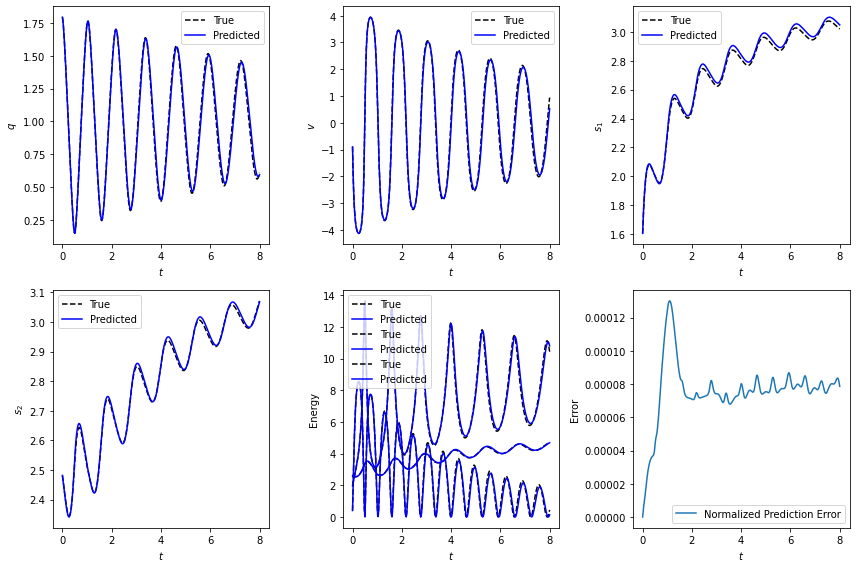

In [1]:
import sys
sys.path.append(r'./gfinn_gc')

import learner_gfinn as ln
import torch
import numpy as np
import argparse
from data import Data
from nn import *
from postprocess_gc import plot_GC
        
def main(net, lam, seed):
    device = 'cpu' # 'cpu' or 'gpu'
    dtype = 'float'
    # data
    p = 0.8
    problem = 'GC'
    t_terminal = 8
    dt = 0.02
    iters = 1
    trajs = 100
    order = 2
    sigma = 1
    init = [1,0,2,2]
    
    data = Data(p, problem, t_terminal, dt, trajs, order, iters, sigma = sigma, init=init, new = True, noise = 0)
    # NN
    ind = 4
    layers = 5
    width  = 30
    activation = 'tanh'

    batch_size = 100
    lr = 0.001

    if net == 'gfinn2a':
        S = GC_S()
        E = GC_E()
        netS = gfinn_LNN(S, ind = ind, K = ind, layers = layers, width = width, activation = activation, deriv = True)
        netE = gfinn_MNN(E, ind = ind, K = ind, layers = layers, width = width, activation = activation, deriv = True)
        net = GFINN(netS, netE, data.dt / iters, order = order, iters = iters)
    elif net == 'gfinn2b':
        S = ln.nn.FNN(ind, 1, layers=1, width=width, activation=activation)
        E = ln.nn.FNN(ind, 1, layers=layers, width=width, activation=activation)
        netS = gfinn_LNN(S, ind = ind, K = ind, layers = layers, width = width, activation = activation)
        netE = gfinn_MNN(E, ind = ind, K = ind, layers = layers, width = width, activation = activation)
        net = GFINN(netS, netE, data.dt / iters, order = order, iters = iters)
    elif net == 'gnode2a':
        S = GC_S()
        E = GC_E()
        netS = gnode_LNN(S, ind = ind, deriv = True)
        netE = gnode_MNN(E, ind = ind, K = ind, deriv = True)
        net = GFINN(netS, netE, data.dt / iters, order = order, iters = iters)
    elif net == 'gnode2b':
        S = ln.nn.FNN(ind, 1, layers=1, width=width, activation=activation)
        E = ln.nn.FNN(ind, 1, layers=layers, width=width, activation=activation)
        netS = gnode_LNN(S, ind = ind)
        netE = gnode_MNN(E, ind = ind, K = ind)
        net = GFINN(netS, netE, data.dt / iters, order = order, iters = iters)
    else:
        raise NotImplementedError
    
    # training
    iterations  = 200000
    lbfgs_steps = 0
    print_every = 100
    path = problem + str(lam) + '_' + str(seed) 
    callback = None
    
    args2 = {
        'data': data,
        'net': net,
        'criterion': None,
        'optimizer': 'adam',
        'lr': lr,
        'iterations': iterations,
        'lbfgs_steps': lbfgs_steps,
        'batch_size': batch_size,
        'print_every': print_every,
        'save': True,
        'path': path,
        'callback': callback,
        'dtype': dtype,
        'device': device,
    }
    
    ln.Brain.Init(**args2)
    ln.Brain.Run()
    ln.Brain.Restore()
    ln.Brain.Output()
    plot_GC(data, net)
        
if __name__ == '__main__':  
    seed = 3
    lam = 0
    torch.manual_seed(seed)
    np.random.seed(seed)
    main('gfinn2a', lam, seed)

## Neural ODE

In [2]:
!pip install torchdiffeq

import torch
import torch.nn as nn
import torch.optim as optim
import torchdiffeq 
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

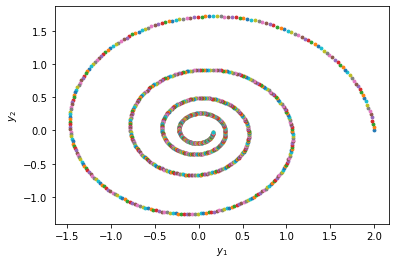

In [52]:
data_size=1000
method='dopri5'
batch_size=20
batch_time=10
niters=2000
test_freq=10
viz='store_true'
adjoint='store_true'

# Generate Training Data
y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
A = torch.tensor([[-0.1, 1.0], [-1.0, -0.1]])

class F(nn.Module):
    def forward(self, t, y):
        return torch.mm(y, A)
    
with torch.no_grad():
    y_actual = odeint(F(), y0, t, method='dopri5')

y_actual_np = y_actual.numpy()
shp = np.shape(y_actual)

for j in range(shp[0]):
    y1 = y_actual_np[j,0,0]
    y2 = y_actual_np[j,0,1]
    plt.scatter(y1, y2, s=8)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
        
def mini_batch():
    s_temp = np.arange(data_size - batch_time, dtype=np.int64)
    s = torch.from_numpy(np.random.choice(s_temp, batch_size, replace=False))
    batch_y0 = y_actual[s]  # (M, D)  # Batch_time 
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([y_actual[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

by0, bt, by = mini_batch()    

In [74]:
def visualize(true_y, pred_y, odefunc, itr):

    if viz:
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(131, frameon=False)
        ax_phase = fig.add_subplot(132, frameon=False)
        ax_vecfield = fig.add_subplot(133, frameon=False)
        
        #ax.set_title("Epoch: " + str(ep))
        
        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), y_actual.numpy()[:, 0, 0], t.numpy(), y_actual.numpy()[:, 0, 1], 'g-', label="Actual")
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--', label="Predicted")
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)

        ax_phase.cla()
        ax_phase.set_title('Phase')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(y_actual.numpy()[:, 0, 0], y_actual.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)
        fig.tight_layout()
        plt.draw()
        plt.pause(0.001)
        plt.show(block=False)
        return fig


Iter 00065 | Total Loss 1.10178494


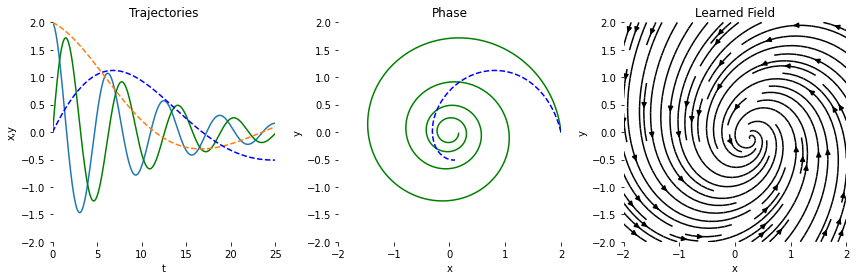

Iter 00065 | Total Loss 1.16603744


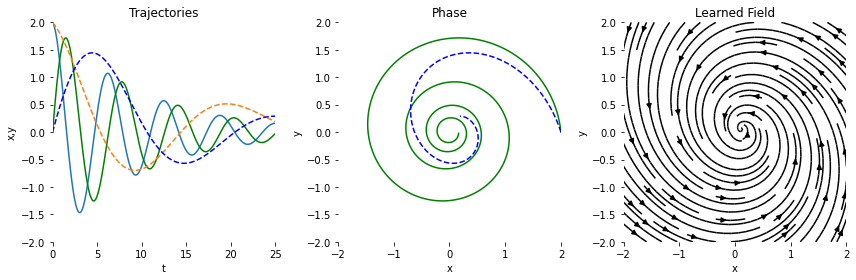

Iter 00065 | Total Loss 1.28212798


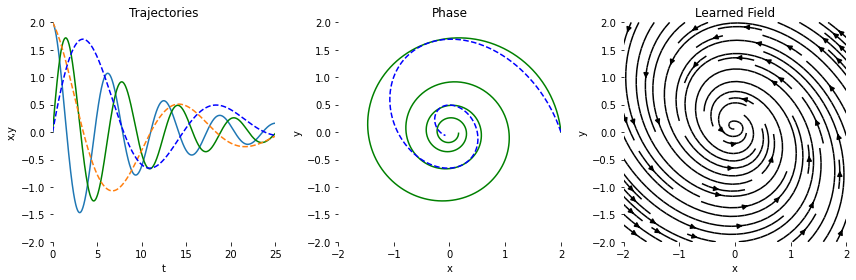

Iter 00065 | Total Loss 1.22219503


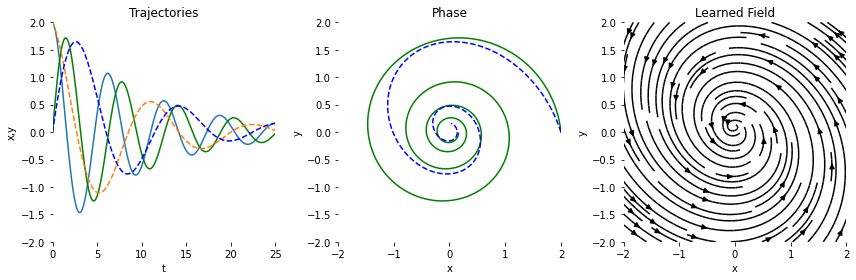

Iter 00065 | Total Loss 1.20104325


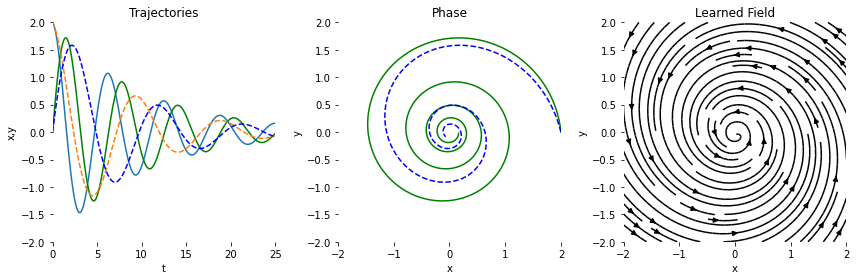

Iter 00065 | Total Loss 1.19288194


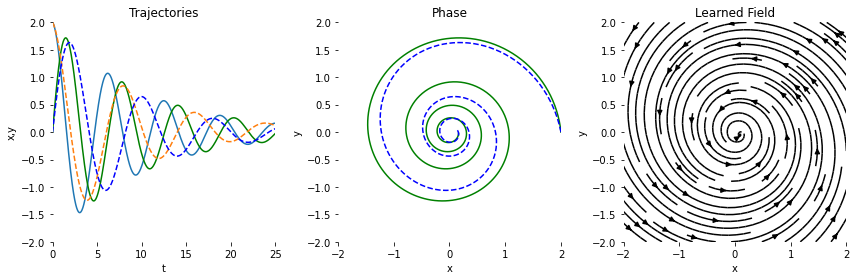

Iter 00065 | Total Loss 1.23787892


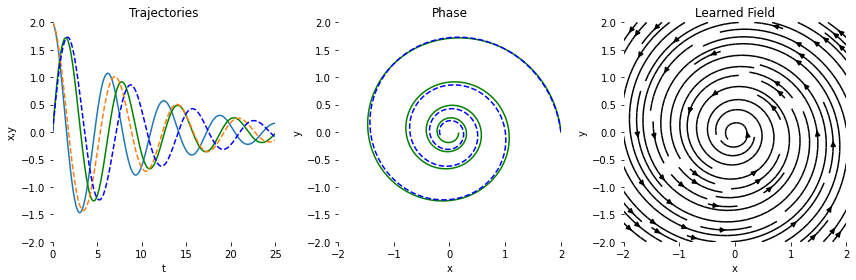

Iter 00065 | Total Loss 1.25207055


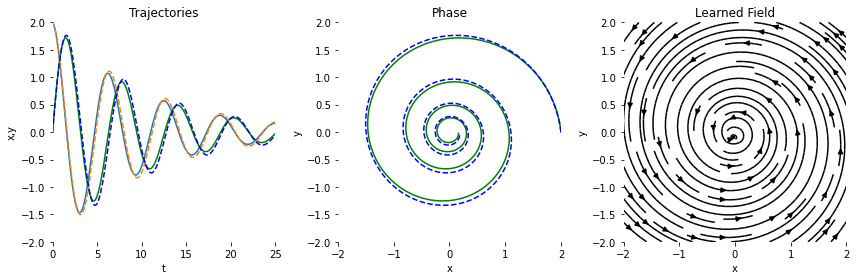

Iter 00065 | Total Loss 1.23542380


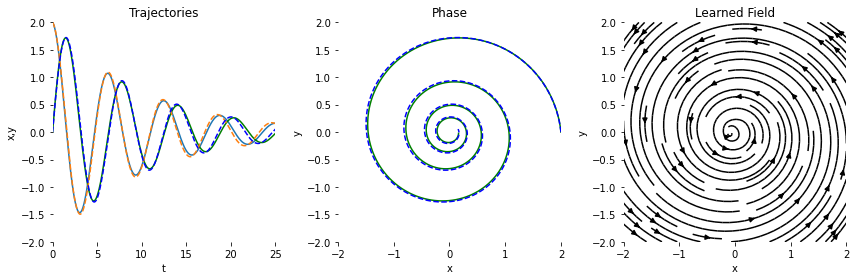

Iter 00065 | Total Loss 1.19003272


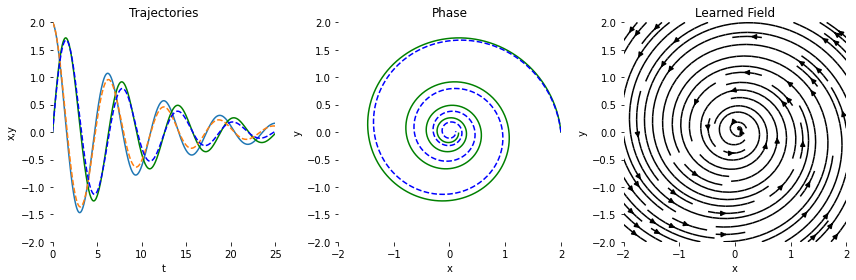

Iter 00065 | Total Loss 1.23112583


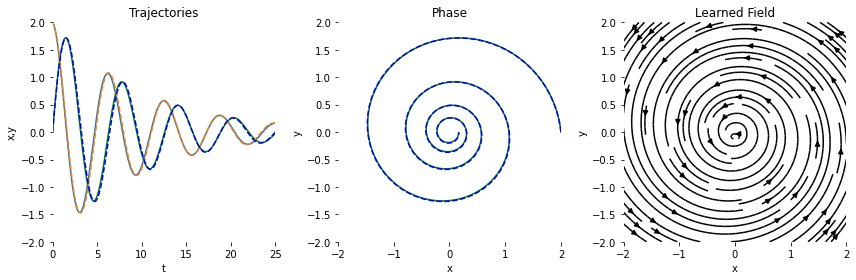

Iter 00065 | Total Loss 1.21778750


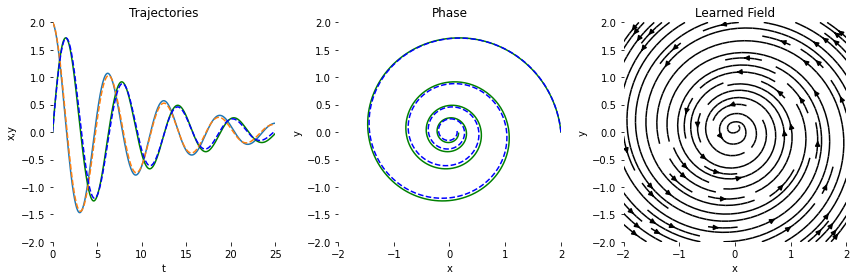

Iter 00065 | Total Loss 1.25954688


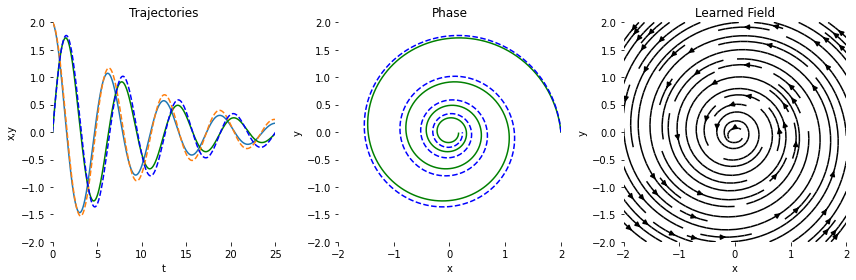

In [75]:
import imageio

class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 40),
            nn.Tanh(),
            nn.Linear(40, 2),
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
p = 0
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
niters = 65
image_list = []

for it in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = mini_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if it % 5 == 0:
        with torch.no_grad():
            pred_y = odeint(func, y0, t)
            loss = torch.mean(torch.abs(pred_y - y0))
            print('Iter {:05d} | Total Loss {:.8f}'.format(itr, loss.item()))
            fig=visualize(y0, pred_y, func, p)
            fig.canvas.draw()      
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            image_list.append(image)
            p += 1
            

imageio.mimsave('./Dynamic_system.gif', image_list, fps=2)
